# 05 - Full Head Example

We have so far covered most of the main functionalities of the package. In this tutorial, we will repeat what we did in the past tutorial, but in a more realistic context: the human brain. By end of the tutorial you should have a good understanding of what it takes to simulate photon propagation in a human head.

The head we use here is a pre-segmented ICBM152 head atlas. Together with the optode placement, they are shipped with the [NeuroDOT](https://github.com/WUSTL-ORL/NeuroDOT_py) package/toolbox developed by the Optical Radiology Labs at WUSTL. They were loaded, restructured, and saved as .mat files.

In [3]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [4]:
# load the 3D volume
# Note that the data type must be uint8
vol = sio.loadmat('headvol.mat')['mask']
# Load the optode information. This is the example 24x28 pad in NeuroDOT
tmp = sio.loadmat('optode_information.mat')
link = tmp['link']
srcpos = tmp['srcpos']
detpos = tmp['detpos']

In [6]:
# define the parameters for the mesh and the optodes
params = ff.utils.MeshingParams()
params.offset = np.array([-87., -124.,  -76.5])
params.facet_distance = 0.75
params.facet_size = 0.75
params.general_cell_size = 2.0
params.subdomain = np.array([[1, 1.5],
                            [3, 1.5],
                            [5, 1.5]])

# optical property at 850nm
# 1: csf; 2: white; 3: gray; 4: bone; 5: skin
optical_props = np.array([[1, 0.004, 0.3, 1.4],
                [2, 0.0208, 1.0107, 1.4],
                [3, 0.0192, 0.6726, 1.4],
                 [4, 0.0139, 0.84, 1.4],
                 [5, 0.0190, 0.64, 1.4]])

# optodes
sources = ff.base.optode(srcpos)
detectors = ff.base.optode(detpos)

# create the mesh
mesh = ff.base.stndmesh()
mesh.from_volume(vol, param=params, prop=optical_props, src=sources, det=detectors, link=link)

Running CGAL mesher
Meshing...

Running Lloyd smoothing... (up to 120s)

Running local optimization...

Converting to NIRFAST format


(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

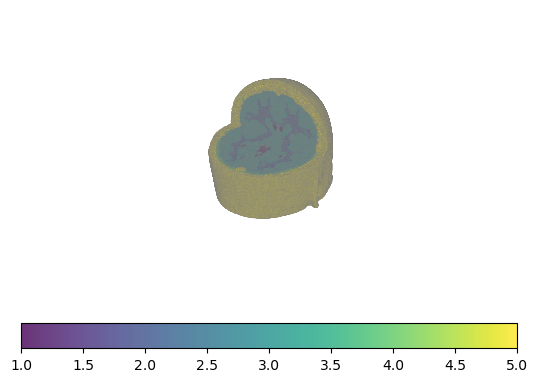

In [11]:
# let's have a look
ff.visualize.plot3dmesh(mesh, mesh.region, '(y>0) | (z<0)')

As you can see, we just generated a rather dense mesh. Depending on your computer's CPU power, that could have taken a while. However, this is in general the quality of the mesh you need for accurate DOT reconstruction. 

Now let's generate some forward data.

In [15]:
# define the grid space
xgrid = np.arange(-87., 88., 2.)
ygrid = np.arange(-120., 40., 2.)
zgrid = np.arange(-75., 100., 2.)
# This can take a few seconds and is heavily bottlenecked by CPU
mesh.gen_intmat(xgrid, ygrid, zgrid)

In [16]:
# cw data
data = mesh.femdata(0)[0]

/var/folders/x8/cr7bc06s70z4snmwjhnncdkw0000gn/T/ipykernel_22407/3587072073.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data.phi[:,32,:,12]).squeeze().T, origin='lower')


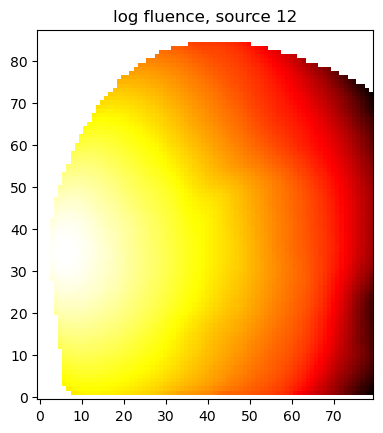

In [23]:
# now have a look
plt.set_cmap('hot')
plt.imshow(np.log(data.phi[:,32,:,12]).squeeze().T, origin='lower')
plt.title('log fluence, source 12')
plt.show()

Finally, let's save the mesh

In [24]:
mesh.save_nirfast('headmesh')